In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from binance_utils import *
import statsmodels.api as sm
from keras.models import load_model
import dask.dataframe as dd

from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# Cargar datos:
df = pd.read_parquet('datasets/merged_data.parquet')

# Establecer 'timestamp' como índice:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index('timestamp', inplace=True)

# Análisis Exploratorio de Datos

## Validación de datos

In [3]:
# Calcular las diferencias en segundos
time_diff_seconds = df.index.to_series().diff().dt.total_seconds()

# Calcular la media de las diferencias
time_mean_diff_seconds = time_diff_seconds.mean()
print("Frecuencia entre observaciones, en segundos: ", time_mean_diff_seconds)

Frecuencia entre observaciones, en segundos:  0.5032822274653643


In [4]:
# Revisamos valores nulos:
null_values = df.isnull().sum()
columns_with_nulls = null_values[null_values > 0]

if not columns_with_nulls.empty:
    print(columns_with_nulls)
else:
    print("No hay valores nulos en el DataFrame.")

No hay valores nulos en el DataFrame.


In [5]:
# # Revisamos filas duplicadas:
# duplicated_rows = df.duplicated().sum()

# if duplicated_rows > 0:
#     duplicated_pct = duplicated_rows / len(df)
#     print(f"Porcentaje de observaciones duplicadas: {duplicated_pct:.2%}")
# else:
#     print("No hay observaciones duplicadas en el DataFrame.")

In [6]:
# Validar consistencia de 'timestamp':
time_diff = df.index.to_series().diff().value_counts()
print(time_diff)

timestamp
0 days 00:00:00.500000768    406877
0 days 00:00:00.500001024    386927
0 days 00:00:00.500001280    375101
0 days 00:00:00.500001536    333432
0 days 00:00:00.500002048    310141
0 days 00:00:00.500000512    244268
0 days 00:00:00.500001792    222360
0 days 00:00:00.500002304    180051
0 days 00:00:00.500002816     99929
0 days 00:00:00.500000256     79793
0 days 00:00:00.500002560     63101
0 days 00:00:00.500003072     32115
0 days 00:00:00.500000         9791
0 days 00:00:00.500003328      1674
0 days 00:10:00.919105024         1
0 days 00:10:00.694799616         1
0 days 00:10:00.684328448         1
0 days 00:10:00.645758208         1
0 days 00:10:02.370601728         1
0 days 00:10:01.053577728         1
0 days 00:10:00.838393856         1
0 days 00:10:00.735068928         1
0 days 00:10:01.408174336         1
0 days 00:10:00.803035904         1
0 days 00:10:00.872205568         1
0 days 00:10:00.729733376         1
0 days 00:10:01.093585664         1
0 days 00:10:01.14

En `time_diff` también se observan saltos temporales atípicos de 10 minutos. Investigamos su naturaleza.

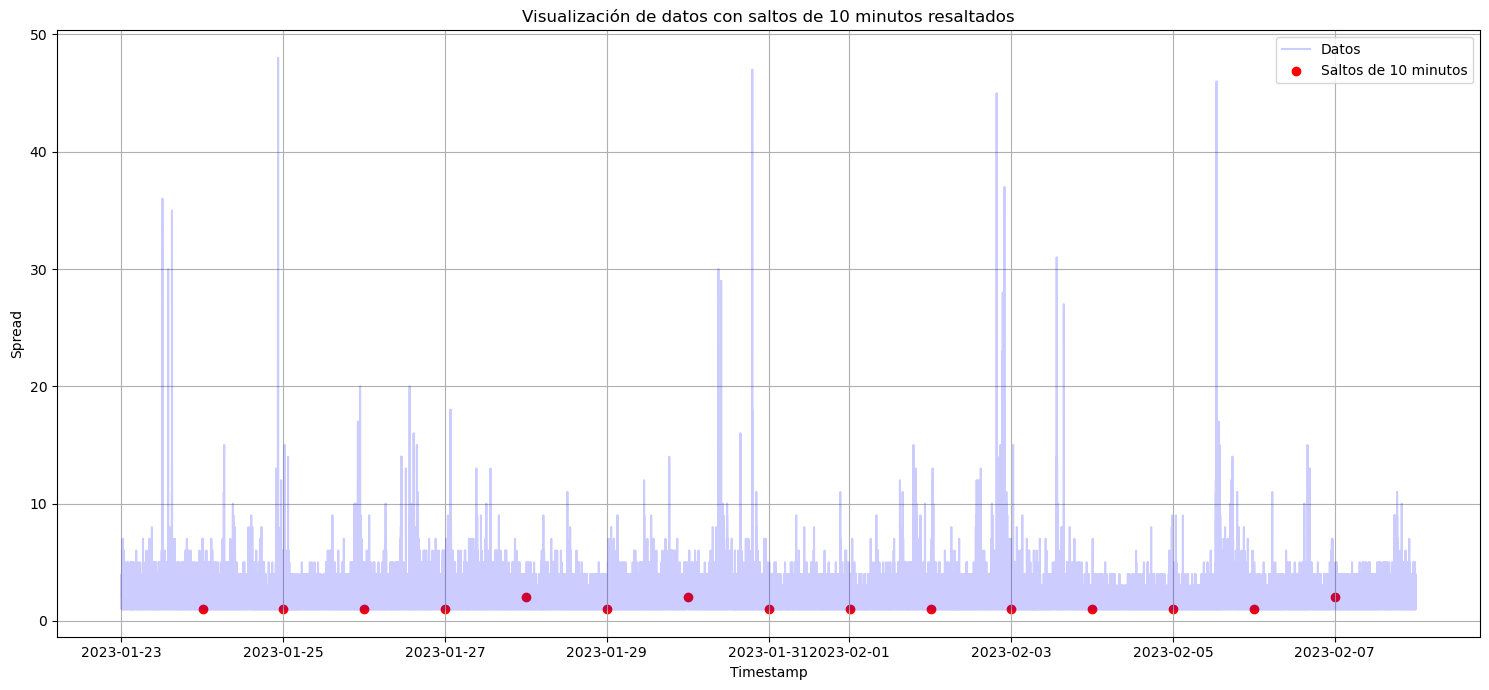

In [7]:
# Asegurarse de que los datos estén ordenados por timestamp:
df_10min = df.reset_index().sort_values(by='timestamp')

# Calcular la diferencia entre timestamps consecutivos:
df_10min['time_diff'] = df_10min['timestamp'].diff()

# Identificar los puntos de interés:
mask = df_10min['time_diff'].abs().between(pd.Timedelta('9 minutes 50 seconds'), pd.Timedelta('10 minutes 10 seconds'))

# Graficar los datos:
plt.figure(figsize=(15, 7))
plt.plot(df_10min['timestamp'], df_10min['spread'], label='Datos', color='blue', alpha=0.2)
plt.scatter(df_10min[mask]['timestamp'], df_10min[mask]['spread'], color='red', label='Saltos de 10 minutos')
plt.xlabel('Timestamp')
plt.ylabel('Spread')
plt.title('Visualización de datos con saltos de 10 minutos resaltados')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# Calcular la diferencia entre timestamps consecutivos:
df_10min['time_diff'] = df_10min['timestamp'].diff()

# Identificar los puntos de interés:
mask = df_10min['time_diff'].abs().between(pd.Timedelta('9 minutes 50 seconds'), pd.Timedelta('10 minutes 10 seconds'))

# Crear una máscara para los puntos inmediatamente posteriores:
next_mask = mask.shift(-1, fill_value=False)

# Combinar las dos máscaras usando el operador "or":
combined_mask = mask | next_mask

# Extraer estos puntos en un nuevo DataFrame:
df_10min_timeskips = df_10min[combined_mask].copy()

df_10min_timeskips.sort_values('timestamp', ascending=True, inplace=True)
df_10min_timeskips.set_index('timestamp', inplace=True)

print("Saltos de 10 minutos detectados:\n", df_10min_timeskips.index)


Saltos de 10 minutos detectados:
 DatetimeIndex(['2023-01-23 23:54:59.459493120',
               '2023-01-24 00:05:00.602287104',
               '2023-01-24 23:54:59.469715200',
               '2023-01-25 00:05:00.563300864',
               '2023-01-25 23:54:59.934701568',
               '2023-01-26 00:05:00.664434944',
               '2023-01-26 23:54:59.788566016',
               '2023-01-27 00:05:00.626959872',
               '2023-01-27 23:54:59.901041408',
               '2023-01-28 00:05:00.773246976',
               '2023-01-28 23:54:59.843753472',
               '2023-01-29 00:05:00.646789376',
               '2023-01-29 23:54:59.372211712',
               '2023-01-30 00:05:00.780386048',
               '2023-01-30 23:54:59.890614528',
               '2023-01-31 00:05:00.625683456',
               '2023-01-31 23:54:59.606319360',
               '2023-02-01 00:05:00.659897088',
               '2023-02-01 23:54:58.416104192',
               '2023-02-02 00:05:00.786705920',
      

Los saltos temporales de 10 minutos ocurren cada vez entre las `23:55:00` y las `00:05:00`. Esto puede tratarse a cierres temporales programados en el sistema de recolección de datos.

### Eliminación de valores atípicos

En este enfoque, consideramos la no eliminación de valores atípicos, pues su presencia garantiza una granularidad media de 0.5 segundos, lo cual es deseado para el entrenamiento de la red LSTM.

Dado que estamos trabajando con una red LSTM para predicciones de series temporales, la consistencia y granularidad de los datos son cruciales. Las LSTMs son sensibles a la secuencia y orden de los datos. Si la eliminación de outliers causa brechas significativas en tus datos, podría ser beneficioso mantenerlos, especialmente si los outliers representan eventos reales.

Sin embargo, al decidir mantener los outliers, es importante tener en cuenta cómo el modelo responde a ellos durante el entrenamiento y validación. Podríamos considerar técnicas como la regularización para evitar el sobreajuste.

Una estrategia intermedia podría ser no eliminar completamente los outliers, sino más bien suavizarlos o ajustarlos a un valor menos extremo, preservando así la granularidad de los datos mientras reducimos el impacto del ruido.

### Visualizaciones

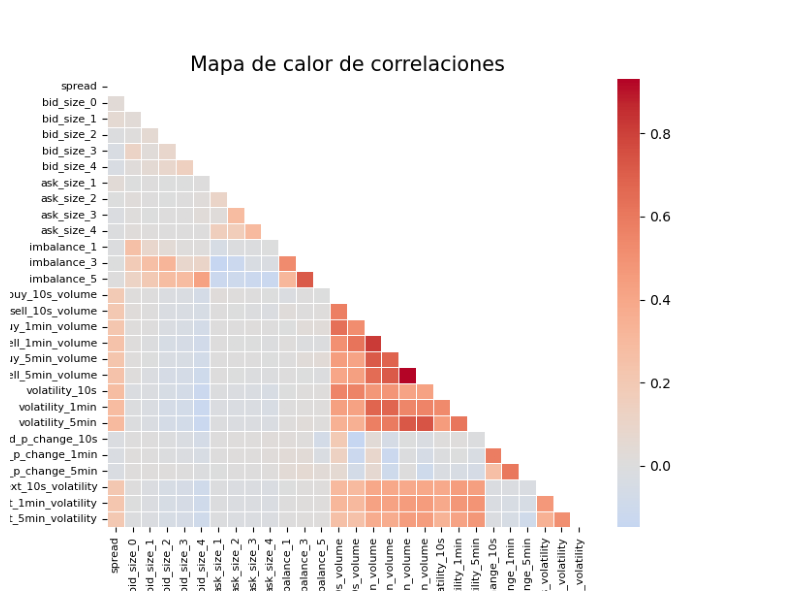

In [9]:
# # Mapa de calor
# corr = df.corr()
# mask = np.triu(np.ones_like(corr, dtype=bool))
# plt.figure(figsize=(8, 6))
# sns.heatmap(data=corr, mask=mask, cmap='coolwarm', center=0, linewidths=0.5, annot=False)
# plt.title('Mapa de calor de correlaciones', size=15)
# plt.xticks(fontsize=8)
# plt.yticks(fontsize=8)
# plt.savefig('images/heatmap_all_outs.png', dpi='figure')
# plt.show()

# Leer la imagen del archivo
img = mpimg.imread('images/heatmap_all_outs.png')
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')
plt.show()

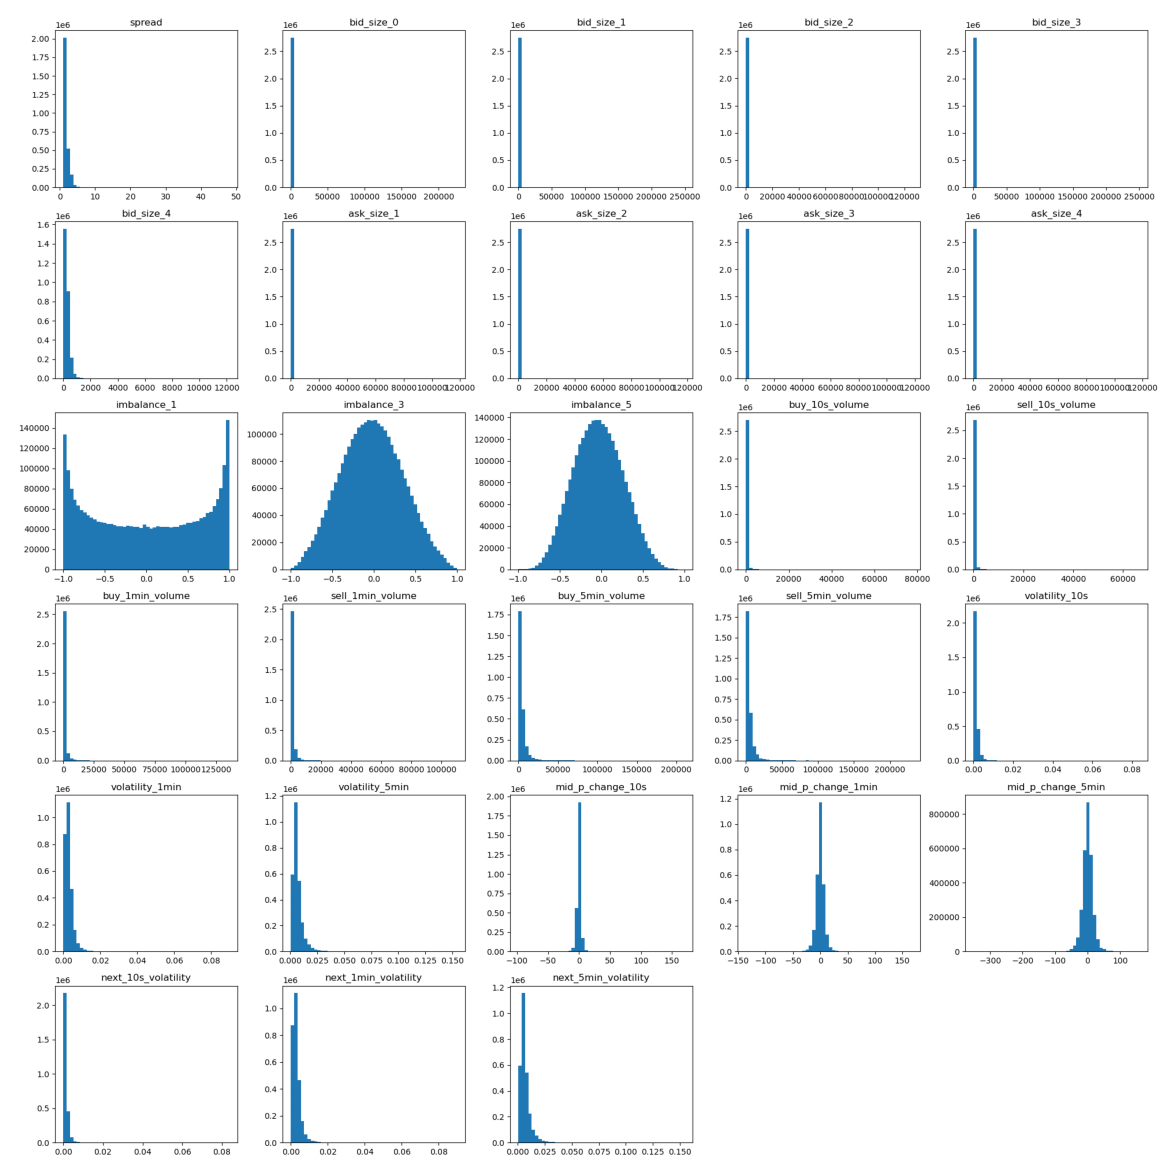

In [10]:
# # Plotear histogramas de cada variable:
# df.hist(figsize=(20, 20), bins=50, grid=False)
# plt.tight_layout()
# plt.savefig('images/hists_all_outs.png', dpi='figure')
# plt.show()

# Leer la imagen del archivo
img = mpimg.imread('images/hists_all_outs.png')
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.axis('off')
plt.show()

Notamos una distribución extraña de la variable objetivo, `mid_p_change_10s`. Efectuamos algunos tests estadísticos para chequear su normalidad, sesgo y curtosis.

In [11]:
import scipy.stats as stats

target_var = 'mid_p_change_10s'

Y = df[target_var]

# Test de Shapiro-Wilk
shapiro_stat, shapiro_p = stats.shapiro(Y)
print(f"Shapiro-Wilk Statistic: {shapiro_stat}, p-value: {shapiro_p}")

# Kurtosis y Asimetría
kurtosis_val = stats.kurtosis(Y)
skewness_val = stats.skew(Y)
print(f"Kurtosis: {kurtosis_val}")
print(f"Skewness: {skewness_val}")

# Test de Anderson-Darling
anderson_result = stats.anderson(Y)
print(f"Anderson-Darling Statistic: {anderson_result.statistic}")
for i in range(len(anderson_result.critical_values)):
    sl, cv = anderson_result.significance_level[i], anderson_result.critical_values[i]
    if anderson_result.statistic < cv:
        print(f"Significance Level: {sl}, Critical Value: {cv} - Se observa una distribución normal")
    else:
        print(f"Significance Level: {sl}, Critical Value: {cv} - No se observa una distribución normal")

c:\Users\ivan_\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-Wilk Statistic: 0.849754810333252, p-value: 0.0
Kurtosis: 49.91505384240342
Skewness: 0.3062055895713917
Anderson-Darling Statistic: 72958.70130326273
Significance Level: 15.0, Critical Value: 0.576 - No se observa una distribución normal
Significance Level: 10.0, Critical Value: 0.656 - No se observa una distribución normal
Significance Level: 5.0, Critical Value: 0.787 - No se observa una distribución normal
Significance Level: 2.5, Critical Value: 0.918 - No se observa una distribución normal
Significance Level: 1.0, Critical Value: 1.092 - No se observa una distribución normal


La prueba de Shapiro-Wilk arrojó un estadístico de 0.8498 y un valor p de 0.0, lo que indica que la distribución no es normal. Además, la kurtosis de la distribución es de 49.9151, lo que sugiere una alta concentración de los datos alrededor de la media, y una asimetría (skewness) de 0.3062, lo que indica una ligera inclinación hacia la derecha. La prueba de Anderson-Darling, que es otra prueba de normalidad, dio un estadístico de 72958.7013. Al evaluar diferentes niveles de significancia, desde el 15% hasta el 1%, en todos los casos los valores críticos (desde 0.576 hasta 1.092) sugieren que no se observa una distribución normal.

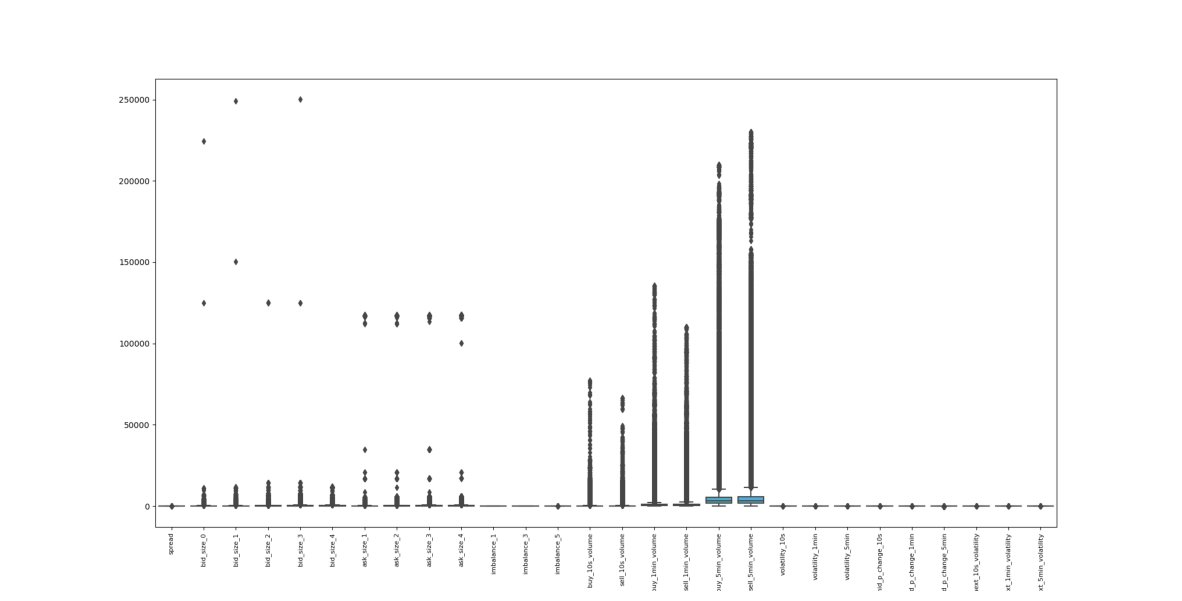

In [12]:
# Boxplots
# plt.figure(figsize=(20, 10))
# sns.boxplot(df)
# plt.xticks(fontsize=8, rotation=90)
# plt.savefig('images/boxplots_all_outs.png', dpi='figure')
# plt.show()

# Leer la imagen del archivo
img = mpimg.imread('images/boxplots_all_outs.png')
plt.figure(figsize=(15,10))
plt.imshow(img)
plt.axis('off')
plt.show()

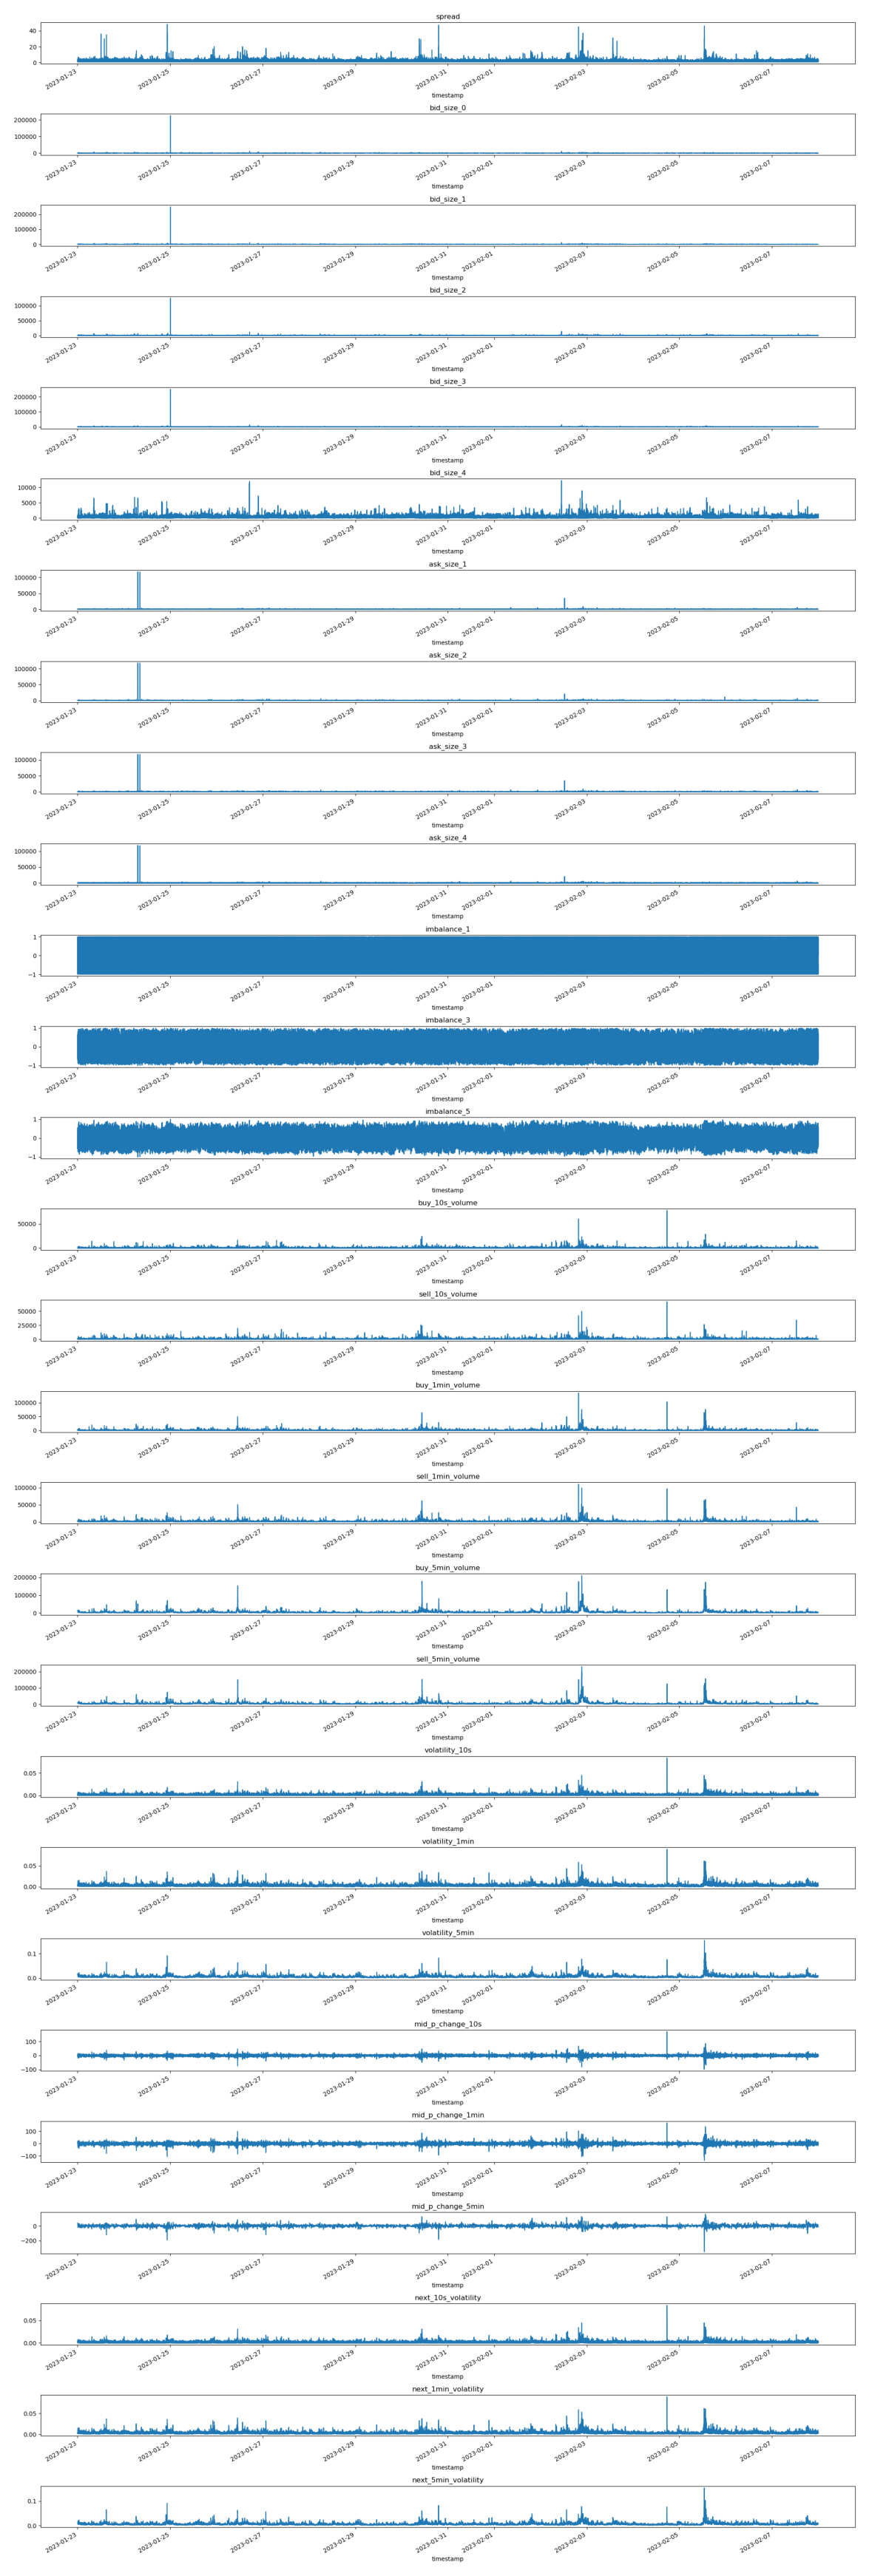

In [13]:
# Plotear líneas de cada variable:
# fig, axs = plt.subplots(len(df.columns), 1, figsize=(20, 60))
# for i, col in enumerate(df.columns):
#     df[col].plot(ax=axs[i], title=col)
# plt.tight_layout()
# plt.savefig('images/lineplots_all_outs.png', dpi='figure')
# plt.show()

# Leer la imagen del archivo
img = mpimg.imread('images/lineplots_all_outs.png')
plt.figure(figsize=(15,45))
plt.imshow(img)
plt.axis('off')
plt.show()

#### Revisión de la granularidad

Revisamos la distribución de observaciones por horas:

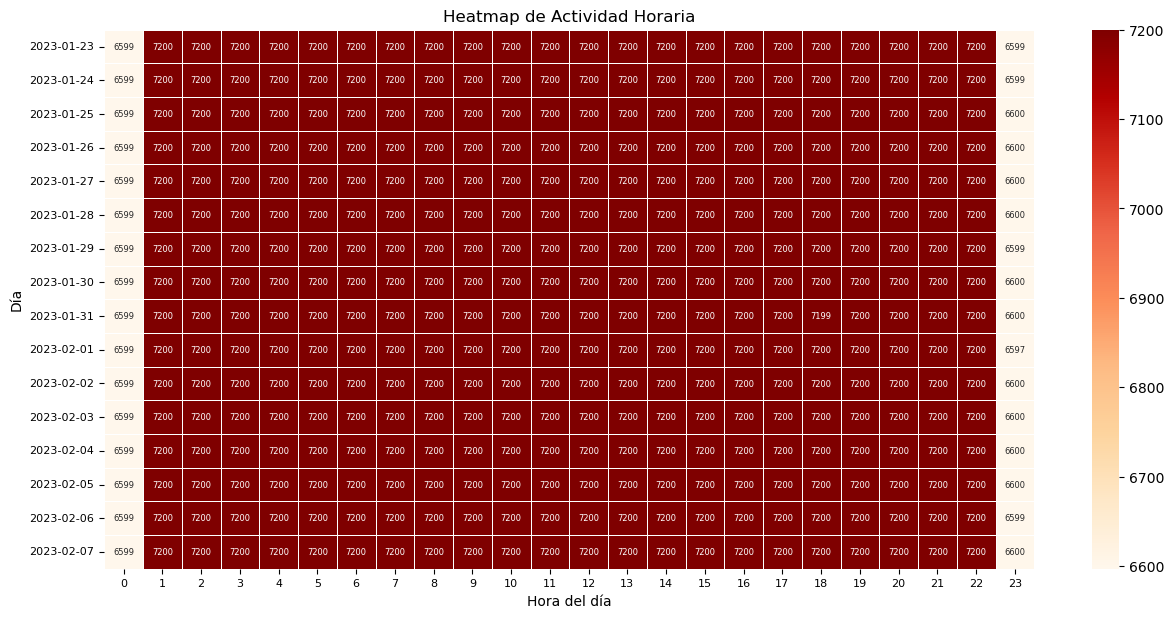

In [14]:
# Remuestrear los datos por hora y cuenta el número de registros por hora
df_resampled = df.resample('H').size().reset_index(name='count')
df_resampled.columns = ['timestamp', 'count']

# Extraer el día y la hora de la columna 'timestamp'
df_resampled['day'] = df_resampled['timestamp'].dt.date
df_resampled['hour'] = df_resampled['timestamp'].dt.hour

# Crear una tabla pivote para el heatmap
heatmap_data = df_resampled.pivot(index='day', columns='hour', values='count')

# Dibujar el heatmap
plt.figure(figsize=(15, 7))
sns.heatmap(heatmap_data, cmap='OrRd', linewidths=0.5, annot=True, fmt=".0f", annot_kws={"size": 6})  # Ajusta el tamaño con "size"
plt.title('Heatmap de Actividad Horaria')
plt.xticks(size=8)
plt.yticks(size=8)
plt.ylabel('Día')
plt.xlabel('Hora del día')
plt.show()

La temperatura de los recuadros representa la cantidad de observaciones contenidas en cada hora, de cada día, a lo largo del dataset. Observamos una distribución consistente y homogénea, consistente con la granularidad media de 0.5 segundos, 7200 por hora.

Los recuadors de color claro indican datos faltantes, aunque también consistentes. Estos corresponden a los 10 minutos de posible cierre del sistema de recolección de datos, a medianoche todos los días.

#### Estacionareidad

La estacionariedad se refiere a una propiedad de las series de tiempo en la cual las características estadísticas (como la media, la varianza y la estructura de autocorrelación) no cambian con el tiempo. En otras palabras, una serie estacionaria tiene propiedades que son consistentes a lo largo del tiempo.

La estacionariedad es importante en el análisis de series de tiempo porque muchos métodos y modelos estadísticos asumen esta propiedad. Si una serie no es estacionaria, puede llevar a predicciones poco fiables o engañosas. Hacer que una serie sea estacionaria a menudo es un paso esencial antes de modelarla, ya que mejora la precisión y la interpretabilidad de los modelos.

Para evaluar la estacionariedad de una serie de tiempo, utilizamos la prueba de Dickey-Fuller aumentada (ADF). Esta prueba verifica la hipótesis nula (H0) de que una unidad de raíz está presente en una muestra de una serie de tiempo. Si la hipótesis nula se rechaza, se puede inferir que la serie de tiempo es estacionaria. El resultado de la prueba es un valor-p, y si este valor es menor que un nivel de significancia determinado (por ejemplo, 0.05), entonces podemos rechazar H0 y considerar que la serie es estacionaria.

Dada la gran cantidad de filas en `df` y el enorme costo computacional de la prueba, ejecutaremos `adfuller()` en una muestra del 10%.

**La evidencia sugiere que todas las variables son estacionarias. Estas fueron evaluadas en su primer 10% con la prueba de Dickey-Fuller.**

In [15]:
# from statsmodels.tsa.stattools import adfuller

# # Obtenemos la muestra del conjunto de datos:
# row_sample = int(df.shape[0] / 10)
# df_sample = df.iloc[:row_sample]

# # Ejecutamos adfuller() en cada columna del conjunto de datos y guardamos los valores-p:
# adfuller_p_values = []

# for col in df.columns:
#     p_value = adfuller(df_sample[col])[1]
#     adfuller_p_values.append(p_value)

# # Creamos un DataFrame que albergue loos valores-p de la prueba:
# adfuller_p_values_df = pd.DataFrame(
#     {'Series': df.columns,
#     'adfuller_p_values': adfuller_p_values}
# )
# # Verificamos si los valores-p son inferiores al umbral de significancia:
# adfuller_p_values_df['H0_rejected'] = adfuller_p_values_df['adfuller_p_values'] < 0.05

# # Guardamos los valores-p obtenidos en un archivo csv:
# adfuller_data = adfuller_p_values_df.to_csv('eda/adfuller_all_outs.csv')

# Imprimimos:
adfuller_data = pd.read_csv('eda/adfuller_all_outs.csv', index_col=0)
adfuller_data

Series  adfuller_p_values  H0_rejected
0                 spread       0.000000e+00         True
1             bid_size_0       0.000000e+00         True
2             bid_size_1       0.000000e+00         True
3             bid_size_2       0.000000e+00         True
4             bid_size_3       0.000000e+00         True
5             bid_size_4       0.000000e+00         True
6             ask_size_1       0.000000e+00         True
7             ask_size_2       0.000000e+00         True
8             ask_size_3       0.000000e+00         True
9             ask_size_4       0.000000e+00         True
10           imbalance_1       0.000000e+00         True
11           imbalance_3       0.000000e+00         True
12           imbalance_5       0.000000e+00         True
13        buy_10s_volume       0.000000e+00         True
14       sell_10s_volume       0.000000e+00         True
15       buy_1min_volume       0.000000e+00         True
16      sell_1min_volume       0.000000e+00         True
17       buy_5min_volume       9.930799e-18         True
18      sell_5min_volume       1.690505e-16         True
19        volatility_10s       0.000000e+00         True
20       volatility_1min       0.000000e+00         True
21       volatility_5min       0.000000e+00         True
22      mid_p_change_10s       0.000000e+00         True
23     mid_p_change_1min       0.000000e+00         True
24     mid_p_change_5min       0.000000e+00         True
25   next_10s_volatility       0.000000e+00         True
26  next_1min_volatility       0.000000e+00         True
27  next_5min_volatility       0.000000e+00         True

#### Autocorrelación

In [16]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# # Número de variables
# n_vars = df_sample.shape[1]

# # Creamos una cuadrícula de subgráficos:
# fig, axes = plt.subplots(nrows=n_vars, ncols=2, figsize=(12, 4 * n_vars))

# for i, column in enumerate(df_sample.columns):
#     plot_acf(df_sample[column], lags=50, alpha=0.05, ax=axes[i, 0], title=f"ACF de {column}")
#     plot_pacf(df_sample[column], lags=50, alpha=0.05, ax=axes[i, 1], title=f"PACF de {column}")

# plt.tight_layout()
# plt.savefig('images/acf_pacf_all_outs.png', dpi='figure')
# plt.show()

# # Leer la imagen del archivo
# img = mpimg.imread('images/acf_pacf_all_outs.png')
# plt.figure(figsize=(20,100))
# plt.imshow(img)
# plt.axis('off')
# plt.show()

### Multicolinealidad

Para detectar posible multicolinealidad entre las variables características, utilizamos el factor de inflación de la varianza (VIF). 

In [17]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

Y_list = [target_var, "mid_p_change_1min", "mid_p_change_5min", "next_10s_volatility", "next_1min_volatility", "next_5min_volatility"]

# # Y = df[Y_list]
# Y = df[target_var]

# # Definimos la variable objetivo y variables características escaladas 
# X = df.drop(columns=Y_list)

# # VIF dataframe
# vif_data_all_outs = pd.DataFrame()
# vif_data_all_outs["feature"] = X.columns

# # Calculamos VIF para cada variable característica:
# vif_data_all_outs["VIF"] = [variance_inflation_factor(X.values, i)
#                    for i
#                    in range(len(X.columns))]

# # Almacenar el DataFrame como csv: 
# vif_data_all_outs.to_csv('eda/vif_data_all_outs.csv')

# # Importar datos de VIF:
vif_data_all_outs = pd.read_csv('eda/vif_data_all_outs.csv', index_col=0)
vif_data_all_outs = vif_data_all_outs.sort_values(by="VIF")

# Imprimir VIF:
vif_data_all_outs

feature        VIF
6         ask_size_1   1.163914
7         ask_size_2   1.233426
1         bid_size_0   1.236357
9         ask_size_4   1.296454
8         ask_size_3   1.308001
2         bid_size_1   1.403634
10       imbalance_1   1.492434
4         bid_size_3   1.765008
3         bid_size_2   1.904443
14   sell_10s_volume   2.358865
13    buy_10s_volume   2.433858
5         bid_size_4   2.513378
12       imbalance_5   2.955344
11       imbalance_3   3.331904
19    volatility_10s   3.590526
0             spread   4.390328
20   volatility_1min   5.596584
16  sell_1min_volume   6.023832
15   buy_1min_volume   6.212723
21   volatility_5min   6.326609
17   buy_5min_volume  13.615929
18  sell_5min_volume  14.077995

En `df` hay varias características con multicolinealidad elevada (mayores a 5). Las variables `ask_size_0` y `bid_size_4` presentaban multicolinealidad perfecta, lo que significa que una podía ser representada como una combinación lineal de la otra. Por esta razón, se elminó la primera. También, al crear nuevas variables, aparecerán varias con multicolinalidad perfecta. 

Podemos abordar el problema de multicolinealidad con don enfoques:

1. Eliminar variables con alta multicolinealidad, de mayores a menores y una por una, hasta que tengamos un subconjunto de variables con baja multicolinealidad. Para lograr este enfoque de fuerza bruta, creamos la función `drop_high_vif_vars()`. Si bien esta función elimina variables de forma automática e iterativa, es necesario considerar que puede haber variables eliminadas que sí puedan ser un aporte al modelo, por lo que es necesario utilizarla con cautela.

2. Utilizar modelos de regularización Lasso y Ridge para penalizar, los coeficientes de variables con alta multicolinealidad. 

Este último enfoque es el más eficiente en términos de eficiencia computacional. 

# Ingeniería de características

## Tratamiento de valores atípicos

In [36]:
# Cargar datos:
df = pd.read_parquet('datasets/merged_data.parquet')

# Establecer 'timestamp' como índice:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index('timestamp', inplace=True)

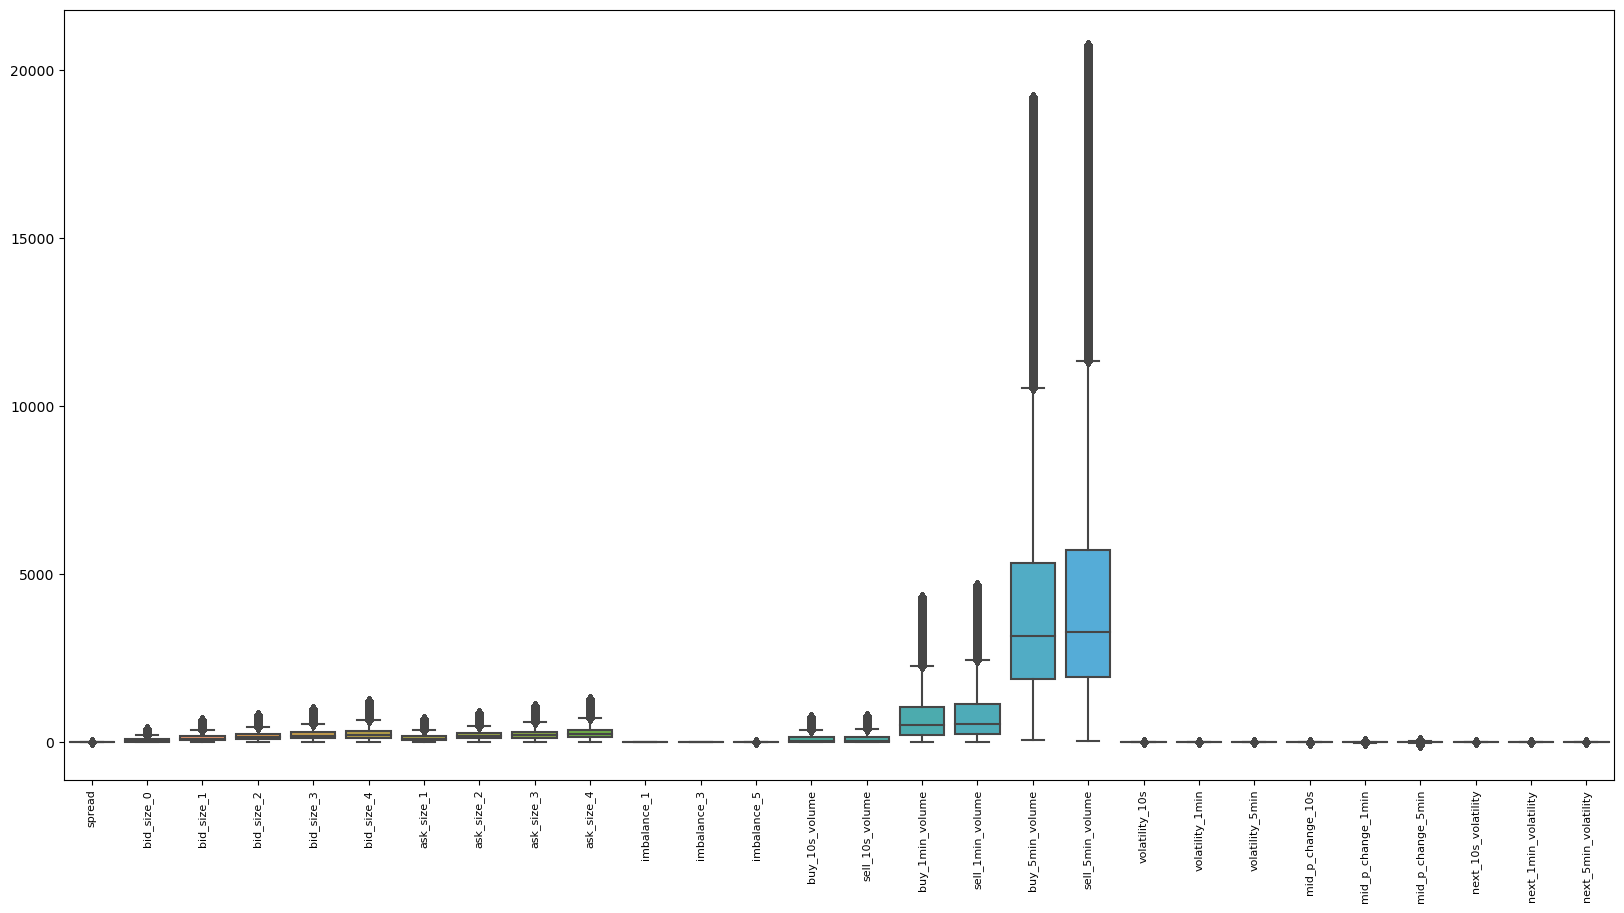

In [37]:
df_capped = pd.DataFrame()

multiplier = 4

for col in df.columns:
    df_capped[col] = apply_outlier_capping(df[col], multiplier=multiplier)

# Boxplots
plt.figure(figsize=(20, 10))
sns.boxplot(df_capped)
plt.xticks(fontsize=8, rotation=90)
plt.show()

df_capped.index = df.index
df = df_capped.copy()

In [38]:
# df_windsorized = pd.DataFrame()

# multiplier = 3

# for col in df.columns:
#     df[col] = apply_windsorizing(df[col], multiplier= multiplier)
    
#     # Boxplots
# plt.figure(figsize=(20, 10))
# sns.boxplot(data=df)
# plt.xticks(fontsize=8, rotation=90)
# plt.show()

## Creación de características

In [39]:
# Variables de 10 segundos
variables_10s = ['spread', 'bid_size_0', 'imbalance_1','buy_10s_volume', 'sell_10s_volume', 'volatility_10s']

for var in variables_10s:
    df[f'{var}_ma_1min'] = df[var].rolling(window=120).mean()  # Media móvil de 1 minuto
    df[f'{var}_ma_5min'] = df[var].rolling(window=600).mean()  # Media móvil de 5 minutos

# Variables de 1 minuto:
variables_1min = ['imbalance_3', 'buy_1min_volume', 'sell_1min_volume', 'volatility_1min']

for var in variables_1min:
    df[f'{var}_ma_5min'] = df[var].rolling(window=600).mean()  # Media móvil de 5 minutos

In [40]:
# Momento
df['momentum_10s'] = df['mid_p_change_10s'] - df['mid_p_change_10s'].shift(20)  # Momentum de 10 segundos
df['momentum_1min'] = df['mid_p_change_1min'] - df['mid_p_change_1min'].shift(120)  # Momentum de 1 minuto
df['momentum_5min'] = df['mid_p_change_5min'] - df['mid_p_change_5min'].shift(600)  # Momentum de 5 minutos

In [41]:
# Cambio en el Desbalance:
df['imbalance_1_change'] = df['imbalance_1'].diff()
df['imbalance_3_change'] = df['imbalance_3'].diff()
df['imbalance_5_change'] = df['imbalance_5'].diff()

In [42]:
# Relación Volumen de Compra/Venta. Nota: El divisor suma 1 para evitar valores infinitos.
df['log_buy_sell_volume_ratio_10s'] = np.log(df['buy_10s_volume'] / (df['sell_10s_volume'] + 1) + 1)
df['log_buy_sell_volume_ratio_1min'] = np.log(df['buy_1min_volume'] / (df['sell_1min_volume'] + 1) + 1)
df['log_buy_sell_volume_ratio_5min'] = np.log(df['buy_5min_volume'] / (df['sell_5min_volume'] + 1) + 1)

In [43]:
# Características Lag, creadas según lo observado en los gráficos de ACF y PACF:
for col in ['spread', 'imbalance_1', 'imbalance_3', 'imbalance_5']:
        df[f'{col}_lag_1'] = df[col].shift(1)

In [44]:
# Características de Interacción:
df['spread_imbalance1'] = df['spread'] * df['imbalance_1']

In [45]:
# Puntuación estándar para ventanas de corto (100), medio (500) y largo (3000) plazo. Nota: El divisor suma 1 para evitar valores infinitos.
df['z_score_spread_100'] = (df['spread'] - df['spread'].rolling(window=100).mean()) / (df['spread'].rolling(window=100).std() + 1)
df['z_score_spread_500'] = (df['spread'] - df['spread'].rolling(window=500).mean()) / (df['spread'].rolling(window=500).std() + 1)
df['z_score_spread_3000'] = (df['spread'] - df['spread'].rolling(window=3000).mean()) / (df['spread'].rolling(window=3000).std() + 1) 

In [46]:
# Variable "bid" acumulativa.
df['bid_total_size'] = df[['bid_size_0', 'bid_size_1', 'bid_size_2', 'bid_size_3', 'bid_size_4']].sum(axis=1)
df.drop(columns=['bid_size_0', 'bid_size_1', 'bid_size_2', 'bid_size_3', 'bid_size_4'], inplace=True)

# Variable "ask" acumulativa.
df['ask_total_size'] = df[['ask_size_1', 'ask_size_2', 'ask_size_3', 'ask_size_4']].sum(axis=1)
df.drop(columns=['ask_size_1', 'ask_size_2', 'ask_size_3', 'ask_size_4'], inplace=True)

# Relación Bid/Ask
df['bid_ask_ratio'] = df['bid_total_size'] / df['ask_total_size']

In [47]:
# Cálculo del Rango Verdadero (TR):
current_value = df['spread']
previous_value = df['spread'].shift(1)

# TR se calcula como el máximo entre: 
# (1) la diferencia entre el valor actual y el anterior, 
# (2) el valor absoluto entre el valor actual y el anterior, 
# (3) el valor absoluto entre el valor anterior y el actual.
df['tr'] = np.maximum(current_value - previous_value, 
                      np.maximum(np.abs(current_value - previous_value), 
                                 np.abs(previous_value - current_value)))

# Cálculo del Rango Verdadero Medio (ATR) usando un promedio móvil simple para un período de 1 hora:
window_size = 60 * 60 * 2  # 1 hora con granularidad de 0.5 segundos
df['atr'] = df['tr'].rolling(window=window_size).mean()

# Eliminar la columna 'tr' ya que es solo un cálculo intermedio:
df.drop(columns=['tr'], inplace=True)

In [48]:
# Eliminar las filas NaN generadas durante la creación de características:
df = df.dropna()

In [49]:
Y_list = ["mid_p_change_10s", "mid_p_change_1min", "mid_p_change_5min", "next_10s_volatility", "next_1min_volatility", "next_5min_volatility"]

# Extraer variables características:
X = df.drop(columns=Y_list)

# Extraer variable objetivo:
target_var = "mid_p_change_10s"
Y = df[target_var]

## Relaciones de las variables características con la variable objetivo

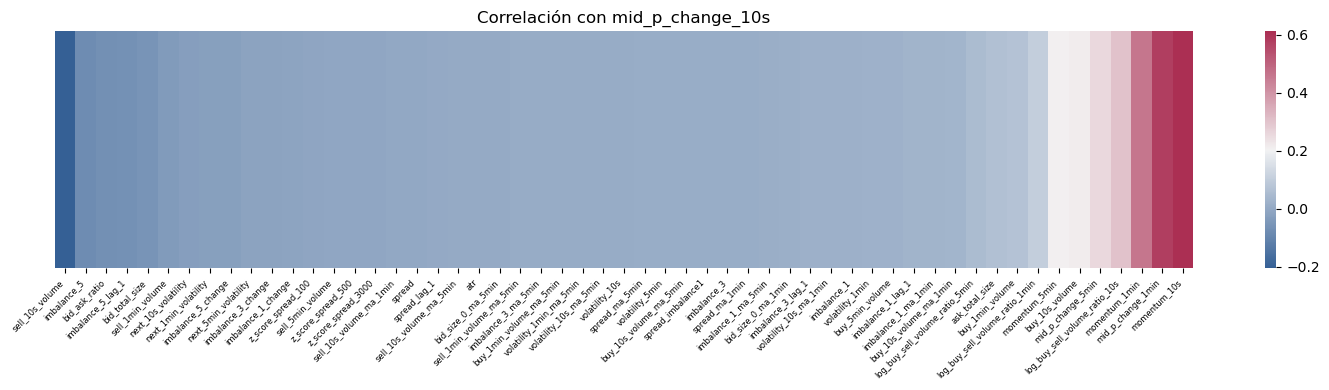

In [50]:
# Calcular la matriz de correlación
corr = df.corr()

# Extraer las correlaciones de 'y' con todas las otras variables
y_corr = corr.loc[:, target_var].sort_values()

# Crear un DataFrame con las correlaciones ordenadas de 'y'
sorted_corr = pd.DataFrame(y_corr).T.drop(columns=[target_var])

# Crear un mapa de colores que va desde azul (frío) a blanco (neutro) a rojo (caliente)
cmap = sns.diverging_palette(250, 0, s=75, l=40, n=9, as_cmap=True)

# Ajustar el tamaño del gráfico para que sea más ancho
plt.figure(figsize=(15, 4))
sns.heatmap(sorted_corr, annot=False, cmap=cmap, cbar=True, linewidths=0, linecolor='none')


# Establecer el título y ajustar las etiquetas
plt.title(f'Correlación con {target_var}')
plt.xticks(rotation=45, ha='right', fontsize=6)

 # Ocultar el nombre del índice en el eje y
plt.yticks([]) 

plt.tight_layout()
plt.show()


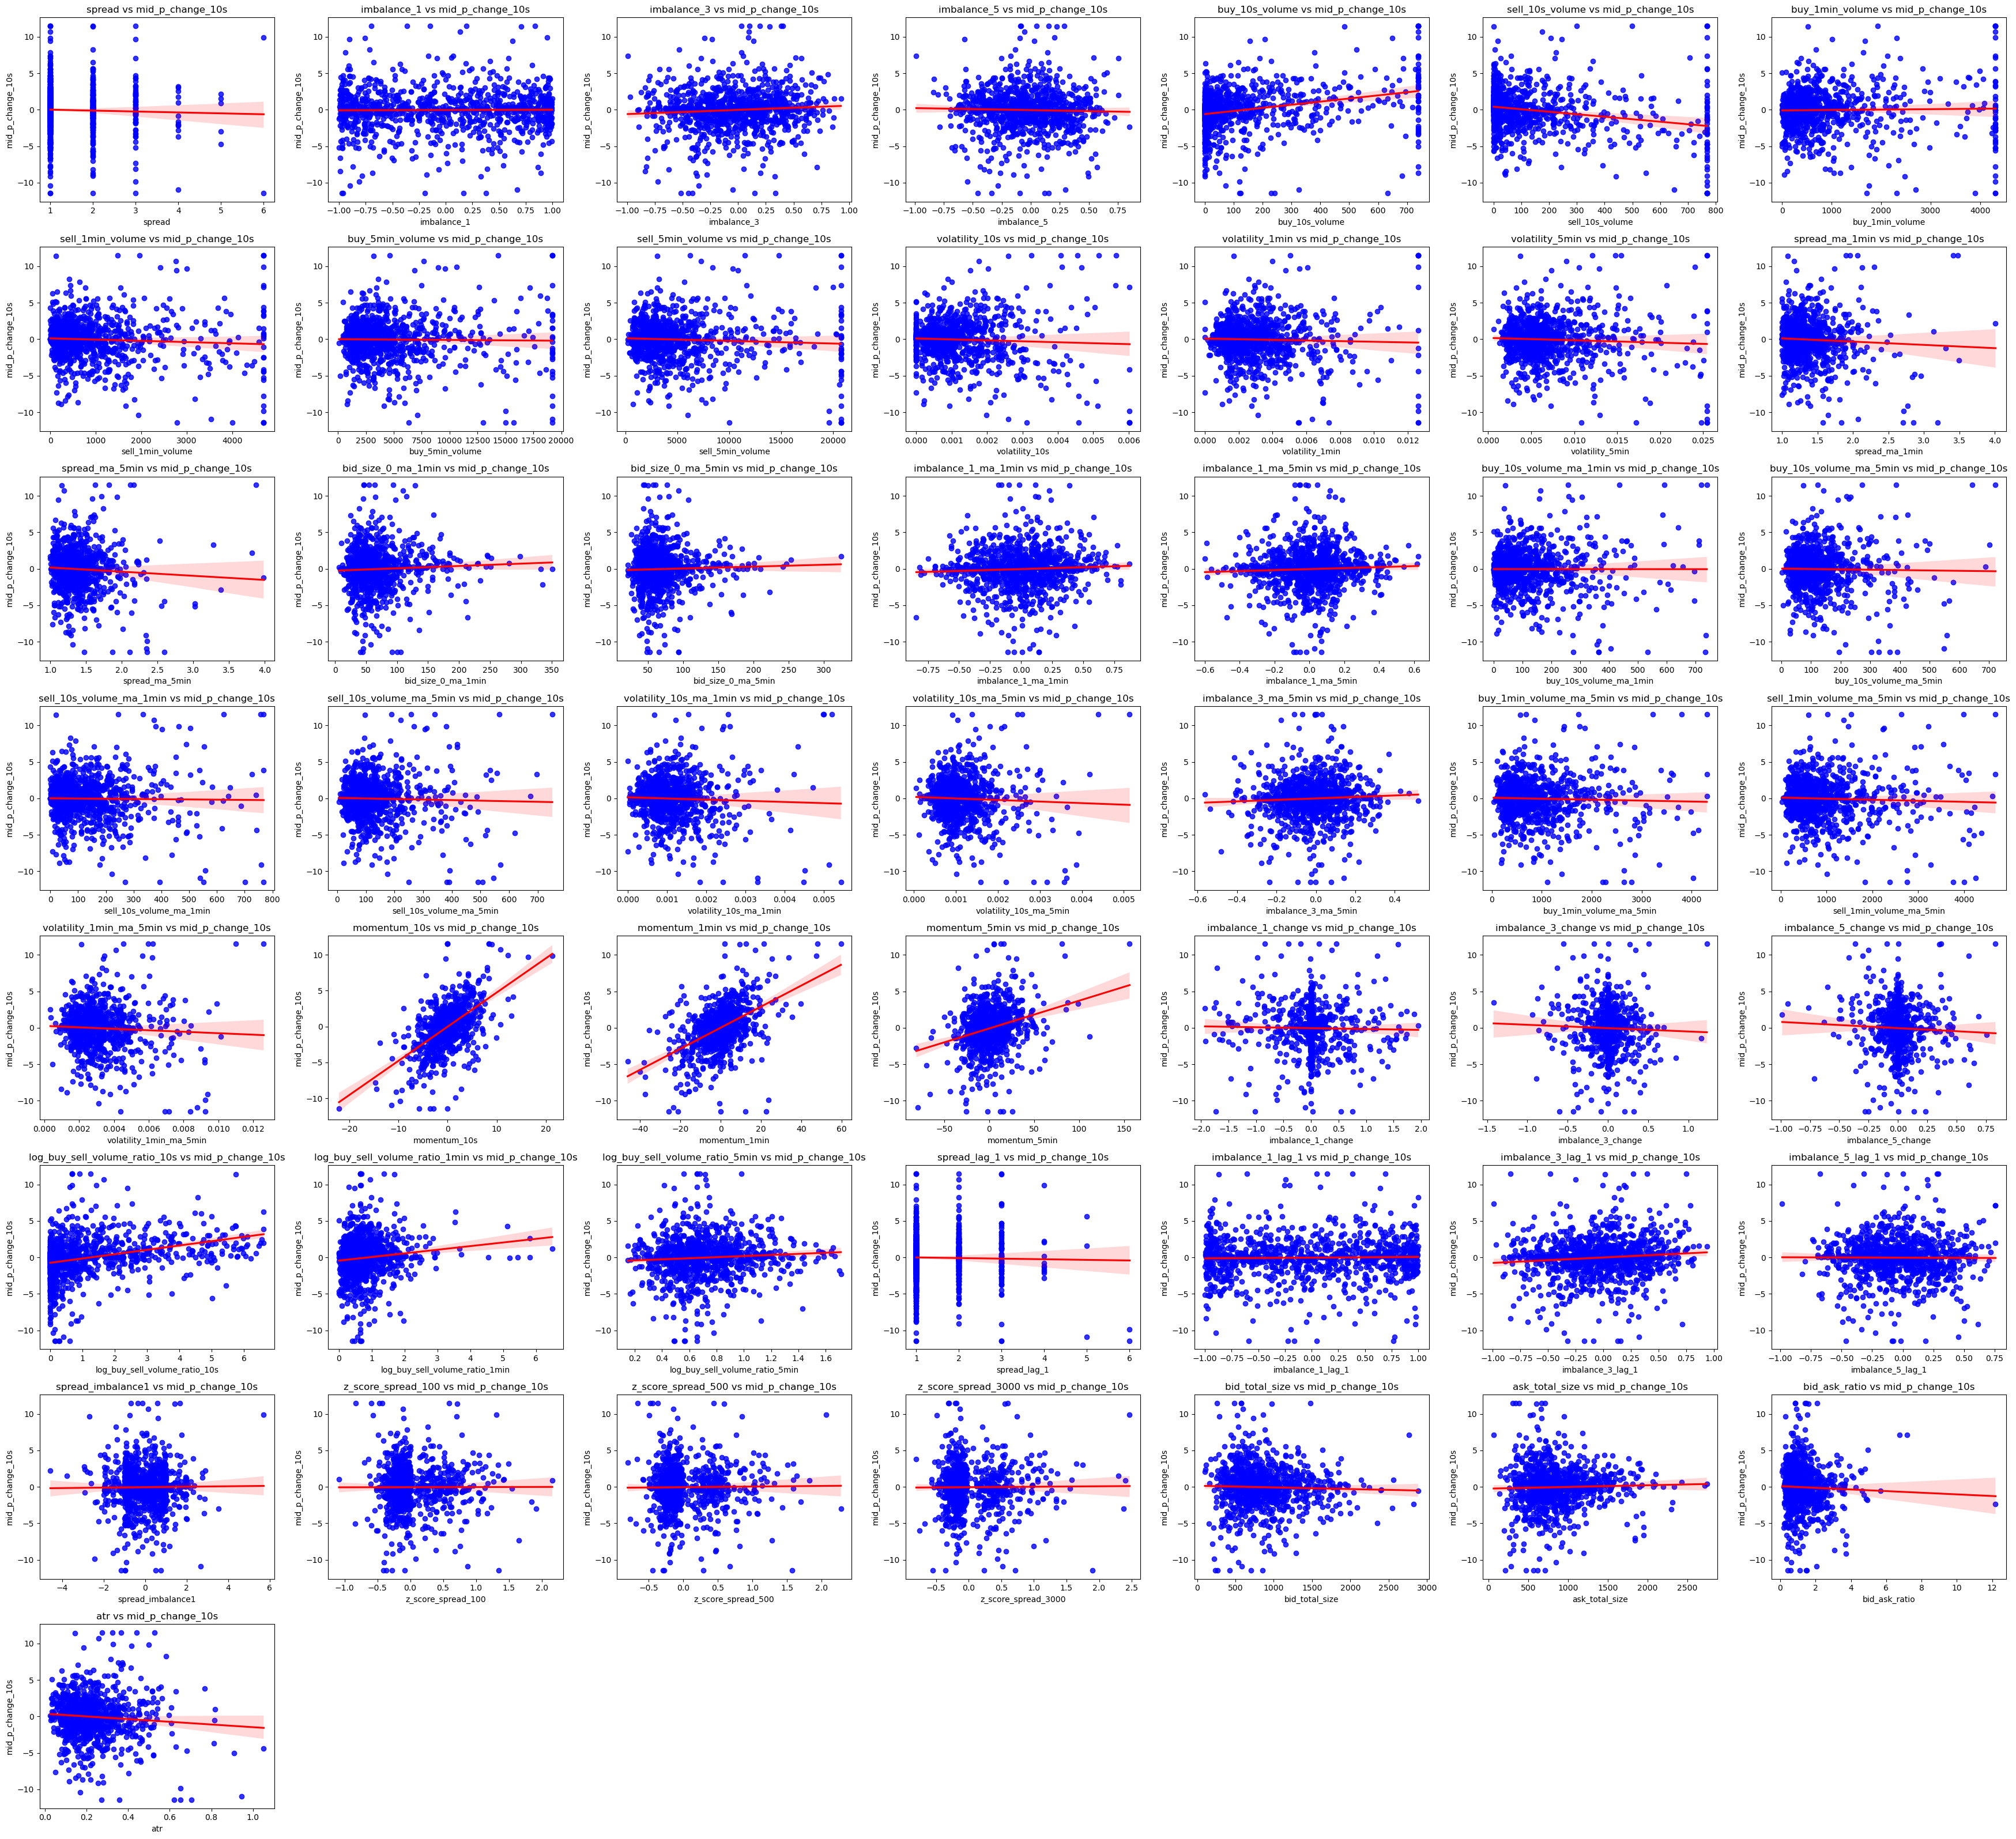

In [51]:
df_sample = df.sample(1000)

X_sample = df_sample.drop(columns=Y_list)
y_sample = df_sample[target_var]

# Número de características en X
num_features = X_sample.shape[1]

# Determinar el número de filas y columnas para la cuadrícula
num_rows = int(np.ceil(np.sqrt(num_features)))
num_cols = int(np.ceil(num_features / num_rows))

# Crear una cuadrícula de subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5*num_cols, 4*num_rows))

# Si solo hay una característica, axes no es una lista, así que lo convertimos en una lista para la iteración
if num_features == 1:
    axes = [axes]

# Aplanar la lista de ejes para facilitar la iteración
axes = np.array(axes).flatten()

# Iterar sobre cada característica y crear un diagrama de dispersión con línea de regresión
for i, col in enumerate(X_sample.columns):
    sns.regplot(x=X_sample[col], y=y_sample, ax=axes[i], color='blue', line_kws={"color": "red"})
    axes[i].set_title(f'{col} vs {target_var}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel(target_var)

# Eliminar cualquier eje adicional que no se use
for j in range(num_features, num_rows*num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Regularización Lasso y Ridge

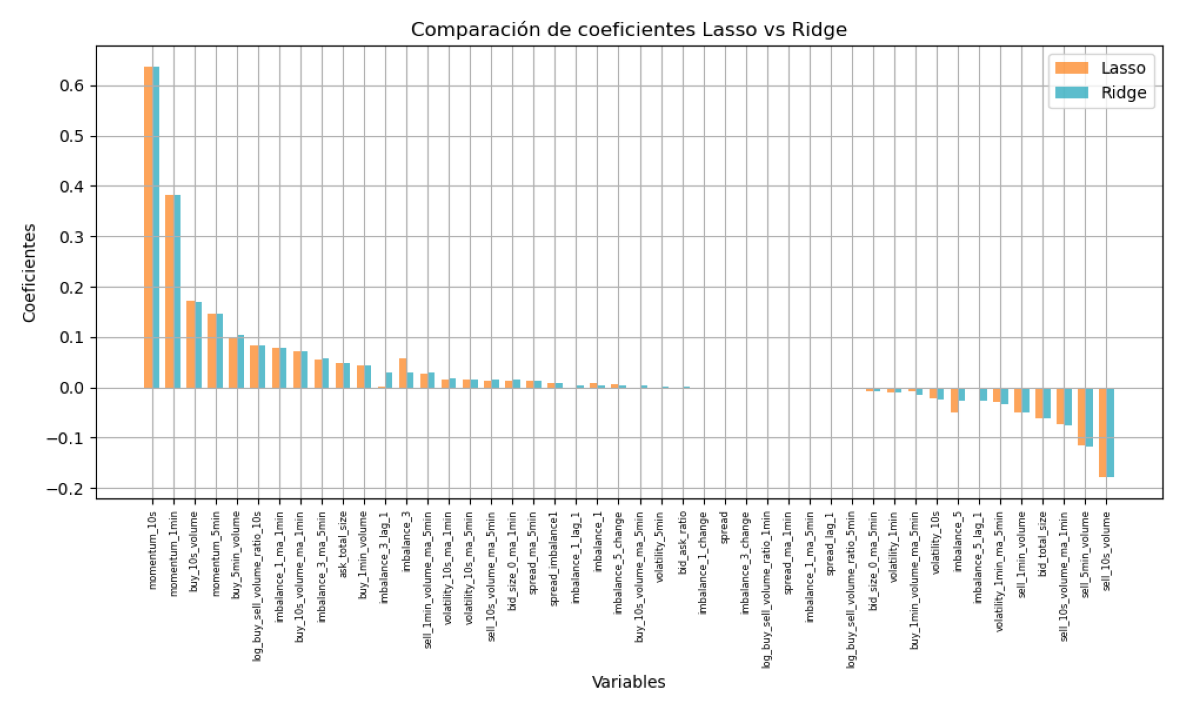

In [52]:
# Leer la imagen del archivo
img = mpimg.imread('images/lasso_ridge_sel.png')
plt.figure(figsize=(15,45))
plt.imshow(img)
plt.axis('off')
plt.show()

## Análisis de Componentes Principales

Núm. de componentes principales que acumulan 99.0% de varianza:  5


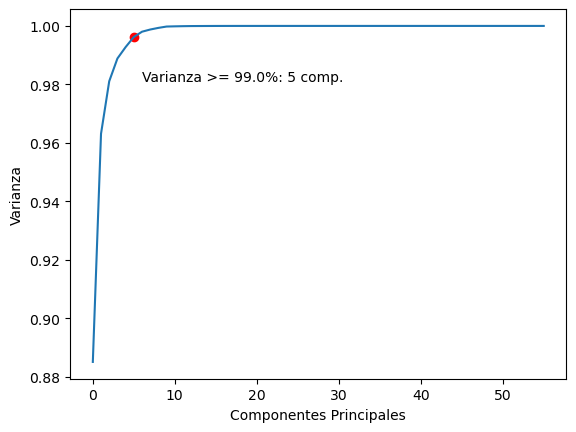

In [53]:
from sklearn.decomposition import PCA

# Instanciamos, ajustamos, transformamos y obtenemos el ratio de varianza explicada:
pca = PCA()
X_pca = pca.fit_transform(df)
exp_variance = pca.explained_variance_ratio_

# Número mínimo de componentes principales que acumulan al menos un valor requerido de varianza:

requested_variance = 0.99
exp_variance_cum_sum = np.cumsum(exp_variance)
n_components = min(np.where(exp_variance_cum_sum >= requested_variance)[0][0] + 1, len(exp_variance_cum_sum) - 1)
#n_components = np.where(exp_variance_cum_sum >= requested_variance)[0][0] + 1
print(f"Núm. de componentes principales que acumulan {requested_variance * 100}% de varianza: ", n_components)

# Graficamos:
plt.plot(exp_variance_cum_sum)
plt.scatter(n_components, exp_variance_cum_sum[n_components], color='red', marker='o')
plt.text(n_components+1, exp_variance_cum_sum[n_components]-.015, f"Varianza >= {requested_variance * 100}%: {n_components} comp.", fontsize=10)
plt.xlabel('Componentes Principales')
plt.ylabel('Varianza')
plt.show()

En la muestra tomada, la prueba de Dickey-Fuller aumentada fuertemente sugiere que las todas series son estacionarias. Este es un dato importante previo al modelado y predicción de los datos. Sin embargo, es necesario actuar con cautela, puesto que carecemos de certeza si los datos se mantienen estacionarios en todo su espacio temporal.

### Selección de características con Random Forest

In [54]:
def sample_time_series(df, percentage, seed=42):
    """
    Toma una muestra continua de una serie de tiempo basada en un porcentaje dado.

    Parámetros:
    - df: DataFrame de la serie de tiempo.
    - percentage: Porcentaje de datos que se desea muestrear (valor entre 0 y 1).
    - seed: Semilla para la generación de números aleatorios.

    Retorna:
    - DataFrame que representa la muestra continua.
    """
    # Establece la semilla para la reproducibilidad
    np.random.seed(seed)

    # Define el tamaño de la muestra
    sample_size = int(len(df) * percentage)

    # Decide un punto de inicio aleatorio, asegurándote de que haya suficientes datos después de ese punto
    # para tomar el porcentaje completo establecido
    max_start_index = len(df) - sample_size
    start_index = np.random.randint(0, max_start_index)

    # Toma el segmento de datos que representa el porcentaje a partir de ese punto de inicio
    return df[start_index:start_index + sample_size]


In [62]:
# Dividir los datos en entrenamiento y prueba:
train_size = int(len(df) * 0.7)
val_size = int(train_size * 0.7)

df_train, df_test = df[:train_size], df[train_size:]
df_train, df_val = df[:val_size], df[val_size:]

sample_size = 0.2

df_train_rf_sample = sample_time_series(df_train, sample_size)
df_val_rf_sample = sample_time_series(df_val, sample_size)
df_test_rf_sample = sample_time_series(df_test, sample_size)

df_rf_sample = pd.concat([df_train_rf_sample, df_val_rf_sample, df_test_rf_sample])

X_rf_sample = df_rf_sample.drop(columns=Y_list)
Y_rf_sample = df_rf_sample[target_var]

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Instanciar y entrenar RF:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_rf_sample, Y_rf_sample)

# Obtener la importancia de las características
feature_importances = rf.feature_importances_

# Crear un DataFrame para visualizar las importancias
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Ordenar las características por importancia
features_df = features_df.sort_values(by='Importance', ascending=False)

# Puedes seleccionar las características más importantes basándote en un umbral o en un número específico de características
RF_X_list = features_df['Feature'][:8].tolist()
RF_X = df[RF_X_list]


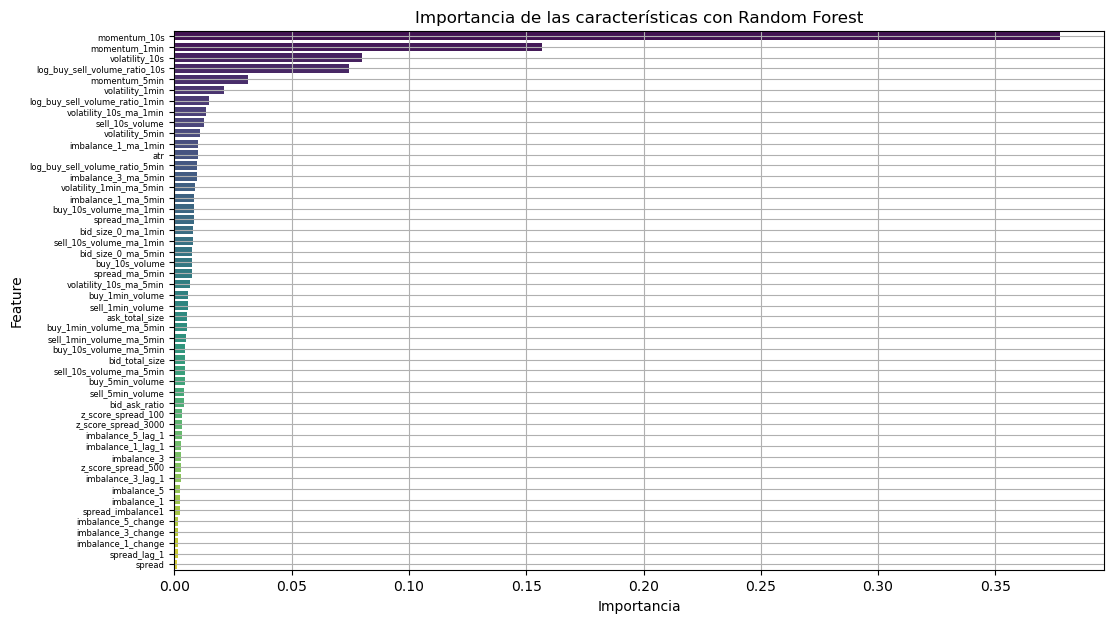

In [75]:
# Establecer la paleta de colores de Seaborn
palette = sns.color_palette("viridis", len(features_df))

# Visualizar la importancia de las características
plt.figure(figsize=(12, 7))
sns.barplot(y="Feature", x="Importance", data=features_df, palette=palette)
plt.xlabel("Importancia")
plt.yticks(size=6)
plt.title("Importancia de las características según Random Forest")
plt.grid()
plt.show()

# Modelo Long Short-Term Memory (LSTM)

### Creación de subconjuntos de datos

In [78]:
from sklearn.preprocessing import RobustScaler
from scipy.stats import yeojohnson

# Escalar las características
X_scaler = RobustScaler()
X_scaled = X_scaler.fit_transform(RF_X)
X_scaled = pd.DataFrame(X_scaled, columns=RF_X.columns, index=RF_X.index)

# Transformación Yeo-Johnson sobre la variable objetivo. 
# La transformación no mejora sustancialmente la predicción pero ayuda a una convergencia más rápida.
yj_Y, lambda_best_fit = yeojohnson(Y)

# Escalar las variables objetivo
Y = pd.DataFrame(yj_Y, index=Y.index)
Y_scaler = RobustScaler()
Y_scaled = Y_scaler.fit_transform(Y)
Y_scaled = pd.DataFrame(Y_scaled, columns=Y.columns, index=Y.index)

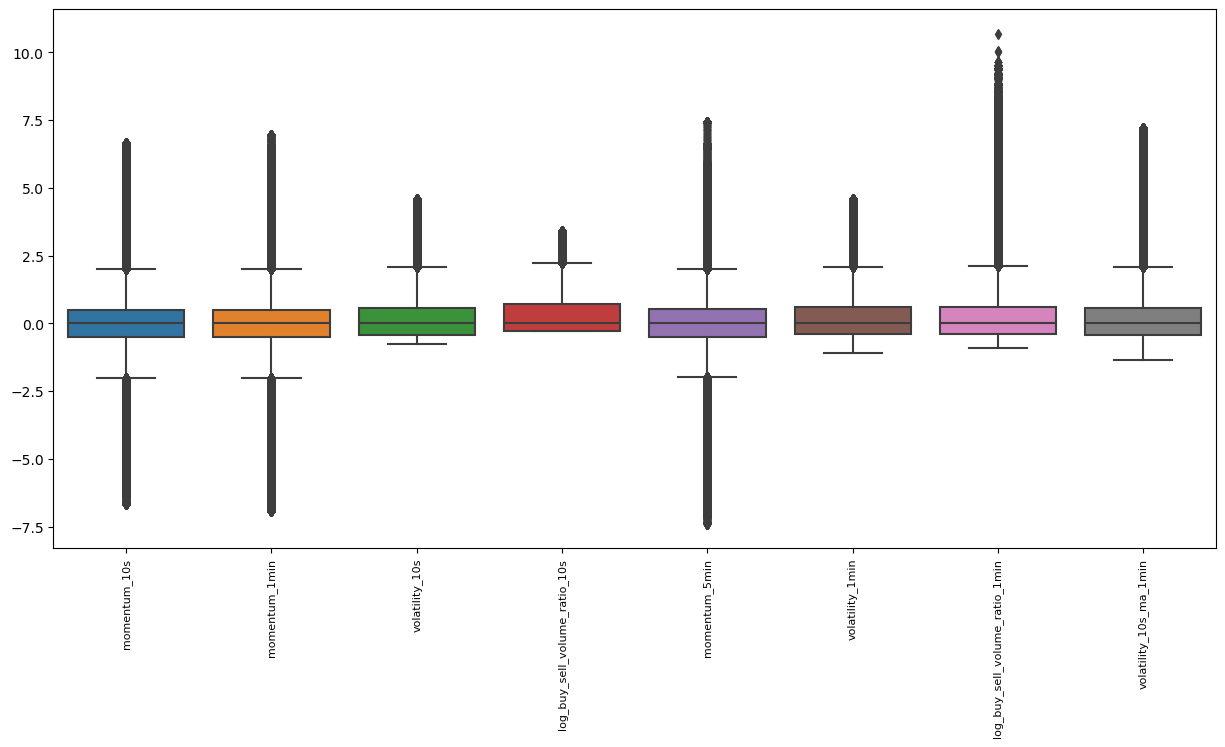

In [79]:
# Boxplots
plt.figure(figsize=(15, 7))
sns.boxplot(X_scaled)
plt.xticks(fontsize=8, rotation=90)
# plt.savefig('images/boxplots_all_outs.png', dpi='figure')
plt.show()

In [80]:
# One-hot encoding para el día de la semana:
days_encoded = pd.get_dummies(X_scaled.index.dayofweek, prefix='day')

# One-hot encoding para la hora del día:
hours_encoded = pd.get_dummies(X_scaled.index.hour, prefix='hour')

# Asegurarse de que los DataFrames codificados tengan el mismo índice que X_scaled:
days_encoded.index = X_scaled.index
hours_encoded.index = X_scaled.index

# Concatenar las columnas codificadas al DataFrame original
X_scaled = pd.concat([X_scaled, days_encoded, hours_encoded], axis=1)
X_scaled = X_scaled.astype('float32')

# Eliminar variables de día y hora de referencia (lunes y hora 0, respectivamente):
X_scaled.drop(columns=['hour_0', 'day_0'], inplace=True)

In [88]:
# Dividir los datos en entrenamiento y prueba:
train_size = int(len(X_scaled) * 0.8)

X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
Y_train, Y_test = Y_scaled[:train_size], Y_scaled[train_size:]

# Invertir el escalado de los datos de prueba a escala original:
Y_test_rescaled = Y_scaler.inverse_transform(Y_test)

# Dividir el conjunto de entrenamiento en entrenamiento (80% de train_size) y validación (20% de train_size)
val_size = int(train_size * 0.7)
X_train, X_val = X_train[:val_size], X_train[val_size:]
Y_train, Y_val = Y_train[:val_size], Y_train[val_size:]

# Cambiar la forma de los datos para LSTM
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.values.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Definir la cantidad de nodos de entrada y de salida:
window_size = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = Y_scaled.shape[1]

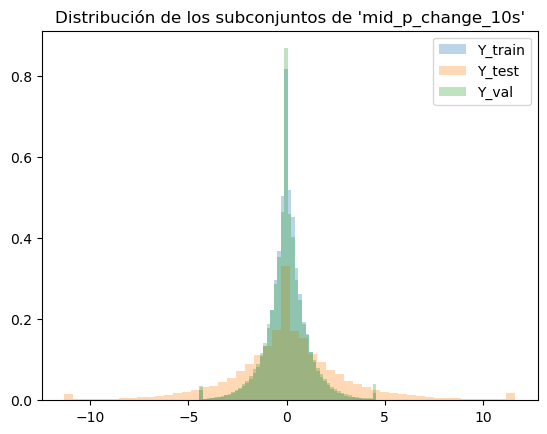

In [89]:
# Visualizar  distribución de variable objetivo:
plt.hist(Y_train, alpha=0.3, density=True, label="Y_train", bins=50)
plt.hist(Y_test_rescaled, alpha=0.3, density=True, label="Y_test", bins=50)
plt.hist(Y_val, alpha=0.3, density=True, label="Y_val", bins=50)
plt.title(f"Distribución de los subconjuntos de '{target_var}'")
plt.legend()
plt.show()

In [90]:
from scipy.stats import ks_2samp

# 2. Prueba de Kolmogorov-Smirnov para comparar las distribuciones
ks_statistic_train_test, ks_pvalue_train_test = ks_2samp(Y_train.values.ravel(), Y_test.values.ravel())
ks_statistic_train_val, ks_pvalue_train_val = ks_2samp(Y_train.values.ravel(), Y_val.values.ravel())
ks_statistic_test_val, ks_pvalue_test_val = ks_2samp(Y_test.values.ravel(), Y_val.values.ravel())

print(f"Prueba KS entre Y_train y Y_test: Estadístico = {ks_statistic_train_test:.4f}, p-valor = {ks_pvalue_train_test:.4f}")
print(f"Prueba KS entre Y_train y Y_val: Estadístico = {ks_statistic_train_val:.4f}, p-valor = {ks_pvalue_train_val:.4f}")
print(f"Prueba KS entre Y_test y Y_val: Estadístico = {ks_statistic_test_val:.4f}, p-valor = {ks_pvalue_test_val:.4f}")

Prueba KS entre Y_train y Y_test: Estadístico = 0.0259, p-valor = 0.0000
Prueba KS entre Y_train y Y_val: Estadístico = 0.0185, p-valor = 0.0000
Prueba KS entre Y_test y Y_val: Estadístico = 0.0098, p-valor = 0.0000


In [129]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Definir optimizador:
lr = 0.0005
optimizer = Adam(learning_rate=lr)

# Dropout generalizado:
dropout = 0.1 # menos malo: 0.1

# Iniciar la red secuencial:
lstm_model = Sequential()

# Primera capa LSTM:
lstm_model.add(
     LSTM(60,
          activation='tanh', 
          input_shape=(window_size, n_features),
          dropout=dropout,
          recurrent_dropout=dropout,
          kernel_regularizer=l2(0.1),        # Subir o bajar incrementa o disminuye el MSE de train y val, pero no disminuye la brecha
          recurrent_regularizer=l2(0.1),
          return_sequences=True  # Esto permite que la salida sea una secuencia, que alimentará la siguiente capa LSTM.
          )
     )

# Capa de dropout previa a la capa densa:
lstm_model.add(Dropout(dropout))

# Segunda capa LSTM:
lstm_model.add(
     LSTM(50,
          activation='tanh',
          dropout=dropout,
          recurrent_dropout=dropout
          )
     )

# Capa densa de salida:
lstm_model.add(Dense(n_outputs))

# Capa de dropout previa a la capa densa:
lstm_model.add(Dropout(dropout))

# Compilar el modelo:
lstm_model.compile(optimizer=optimizer, loss='mse')

# Definir EarlyStopping:
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.0005,
    verbose=1,
    restore_best_weights=True
    )

# Definir el checkpoint del modelo:
checkpoint = ModelCheckpoint(
    'trained_models/best_model.h5',
    monitor='val_loss',
    save_best_only=True
    )

# Entrenamiento del modelo:
train_history = lstm_model.fit(
    X_train,
    Y_train,
    epochs=40,
    batch_size=72,
    validation_data=(X_val, Y_val),
    verbose=2,
    shuffle=False,
    callbacks=[early_stopper, checkpoint]
    )

Epoch 1/40
21299/21299 - 181s - loss: 0.6739 - val_loss: 0.6297 - 181s/epoch - 9ms/step
Epoch 2/40
21299/21299 - 183s - loss: 0.6056 - val_loss: 0.6369 - 183s/epoch - 9ms/step
Epoch 3/40


KeyboardInterrupt: 

In [ ]:
import json

# Guardar el modelo completo en formato HDF5:
lstm_model.save('trained_models/lstm_model_all_outs_2.h5')

# Guardar la historia como JSON:
with open('trained_models/train_history_all_outs_2.json', 'w') as file:
    json.dump(train_history.history, file)

In [ ]:
# Cargar modelo guardado:
lstm_model = load_model('trained_models/lstm_model_all_outs_2.h5')

# Cargar la historia desde JSON:
with open('trained_models/train_history_all_outs_2.json', 'r') as file:
    train_history = json.load(file)

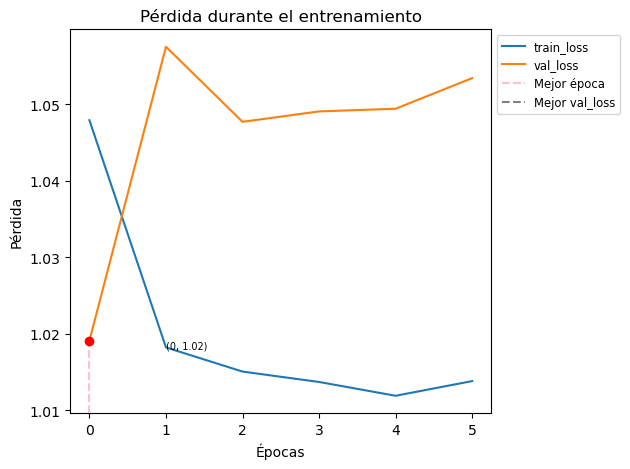

In [ ]:
train_history_df = pd.DataFrame(train_history)

# Plotear los resultados del entrenamiento:
plt.plot(train_history_df['loss'], label='train_loss')
plt.plot(train_history_df['val_loss'], label='val_loss')

# Obtener el índice (época) del mejor valor de pérdida de validación
best_epoch = train_history_df['val_loss'].idxmin()
best_loss = train_history_df['val_loss'].min()

# Agregar líneas punteadas a la coordenada de mejores época y val_loss 
y_ratio = best_loss / plt.ylim()[1]
plt.axvline(x=best_epoch, color='pink', linestyle='--',
            ymax=(best_loss - plt.ylim()[0]) / (plt.ylim()[1] - plt.ylim()[0]), label='Mejor época')
plt.axhline(y=best_loss, color='gray', linestyle='--', xmax=best_epoch/plt.xlim()[1], label='Mejor val_loss')
plt.plot(best_epoch, best_loss, 'ro')

# Mostrar los valores de mejor época y mejor pérdida como coordenadas
plt.text(best_epoch + 1, best_loss, f'({best_epoch}, {best_loss:.2f})',
         color='black', verticalalignment='top', horizontalalignment='left', fontsize=7)

plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.tight_layout()
plt.show()


In [ ]:
# Hacer predicciones
Y_pred = lstm_model.predict(X_test)

# Invertir el escalado para obtener las predicciones en la escala original:
Y_pred = Y_scaler.inverse_transform(Y_pred)

17115/17115 [==============================] - 37s 2ms/step


In [ ]:
# Obtener el MSE de entrenamiento y validación al final del entrenamiento
train_mse = train_history['loss'][-1]
val_mse = train_history['val_loss'][-1]

# MSE en el conjunto de prueba:
test_mse = lstm_model.evaluate(X_test, Y_test_rescaled)

print("RMSE entrenamiento: ", round(train_mse**(0.5), 3))
print("RMSE validación: ", round(val_mse**(0.5), 3))
print("RMSE evaluación:", round(test_mse**(0.5), 3))

# Proporciones sobre entrenamiento:
print("\n")
print("Proporción RMSE entrenamiento: ", round(train_mse**(0.5) / train_mse**(0.5), 3))
print("Proporción RMSE validación: ", round(val_mse**(0.5) / train_mse**(0.5), 3))
print("Proporción RMSE evaluación:", round(test_mse**(0.5) / train_mse**(0.5), 3))

17115/17115 [==============================] - 38s 2ms/step - loss: 8.7599
RMSE entrenamiento:  1.007
RMSE validación:  1.026
RMSE evaluación: 2.96


Proporción RMSE entrenamiento:  1.0
Proporción RMSE validación:  1.019
Proporción RMSE evaluación: 2.94


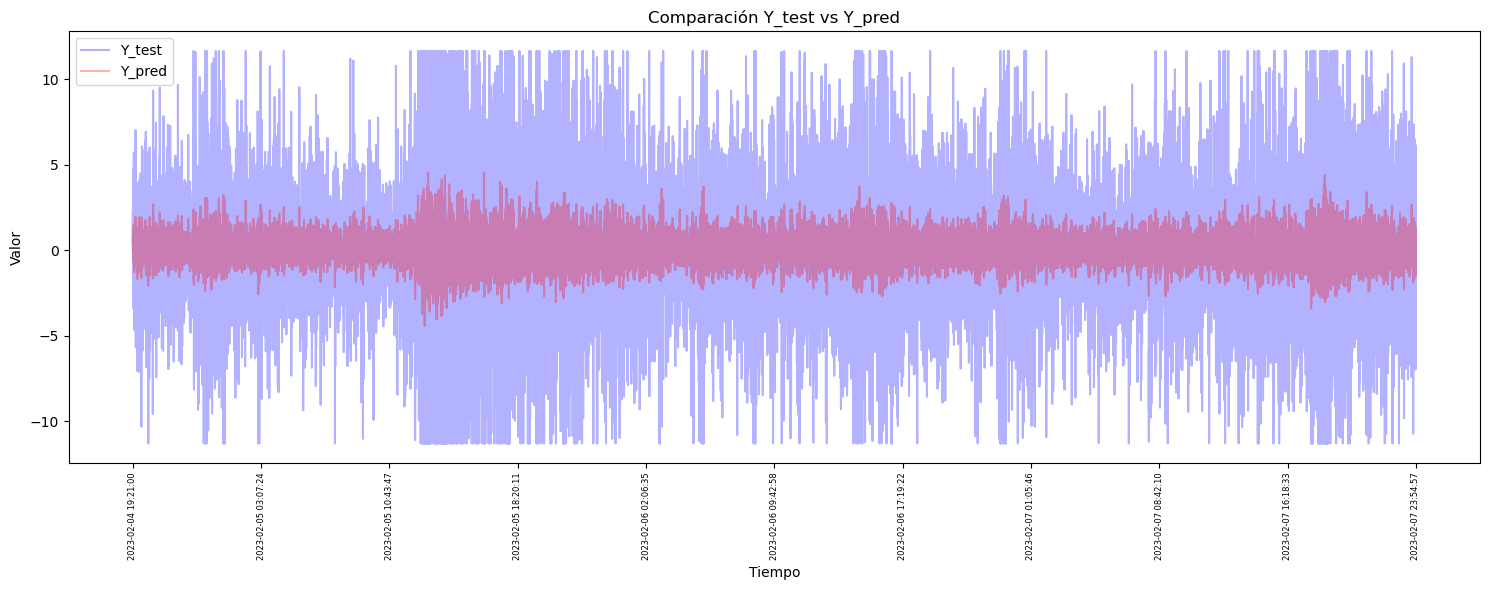

In [ ]:
plt.figure(figsize=(15, 6))

# Graficar los valores reales
plt.plot(Y_test_rescaled, label='Y_test', color='blue', alpha=0.3)

# Graficar las predicciones
plt.plot(Y_pred, label='Y_pred', color='red', alpha=0.3)

# Definir el título y las etiquetas del gráfico
plt.title('Comparación Y_test vs Y_pred')
plt.xlabel('Tiempo')
plt.ylabel('Valor')

# Establecer las etiquetas del eje x usando el índice de tiempo de Y_test
time_labels = Y_test.index.to_list()
positions = list(range(0, len(Y_test_rescaled), len(Y_test_rescaled)//10))  # Tomar 10 puntos equidistantes para las etiquetas
selected_labels = [time_labels[i].strftime('%Y-%m-%d %H:%M:%S') for i in positions]
plt.xticks(positions, selected_labels, rotation=90, size=6)

plt.legend()
plt.tight_layout()
plt.show()